In [2]:
# @title 5) Inicio da normalização e Balanceamento dos dados
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist
from pickle import dump, load
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint
import random

# Carregar dados do arquivo gerado anteriormente (_Raw)
dados = pd.read_csv("PDACCTRL_samplesXfeatures_RAW.csv")
print("Dados carregados:", dados.shape)
dados

Dados carregados: (107, 2581)


,Sample_ID,Grupo,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,...,MIMAT0031119_st,MIMAT0031120_st,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,y
0,GSM2278612,PDAC,1.129491,5.508052,2.923399,1.751963,0.693354,0.750790,0.685247,5.234038,...,0.913821,0.660219,0.484359,0.954552,1.271430,1.405966,0.597030,0.935637,0.930258,1
1,GSM2278613,PDAC,1.727870,7.021726,4.075586,1.692451,0.748297,0.819648,1.228891,3.863134,...,0.572489,0.288395,0.911395,0.865855,1.191414,1.248563,0.880128,0.443996,0.461034,1
2,GSM2278614,PDAC,1.275866,5.847073,4.037849,1.675842,0.792464,0.854456,0.427473,5.030710,...,0.567179,0.585677,0.968250,0.416603,0.906936,0.515170,0.373492,1.029657,0.783717,1
3,GSM2278615,PDAC,1.231164,5.372768,3.634441,1.629729,0.835388,0.508545,0.633179,4.395977,...,0.606826,0.616086,0.910045,0.485816,0.481710,0.658906,0.486607,1.092210,0.877583,1
4,GSM2278616,PDAC,1.598425,5.448495,3.763625,1.970805,0.652223,0.442908,0.477028,4.051217,...,0.798609,0.780584,0.655019,0.591214,1.120507,1.493095,0.723840,0.936191,0.714010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,GSM2278758,Controle,1.072158,6.132864,4.303285,1.466693,1.066174,0.743631,0.542135,4.761716,...,0.565492,0.494150,0.605459,0.665845,1.061685,0.433729,0.351924,0.844252,0.267246,0
103,GSM2278759,Controle,1.688142,5.986205,3.848825,2.162682,0.984778,0.885241,0.934689,4.002943,...,0.829502,0.562959,1.029765,0.616121,0.528186,1.066021,0.886998,0.823196,0.621138,0
104,GSM2278760,Controle,1.507370,5.871728,3.430393,1.897419,0.627474,0.908978,0.458824,4.791717,...,1.177363,0.819254,0.368961,0.541980,1.179273,0.513666,0.789142,1.221342,0.959684,0
105,GSM2278761,Controle,0.588391,6.057384,4.142099,1.870668,1.081216,0.611892,0.771683,5.097688,...,0.604917,0.446808,0.563384,0.238049,0.932333,0.753658,0.141102,1.277319,0.443357,0


In [3]:
#normalizar
dados_num = dados.drop(columns=["Sample_ID", "Grupo", "y"])
dados_cat = dados[["Grupo"]]

#Instanciar o objeto normalizador
normalizador = preprocessing.MinMaxScaler()

#treinar o modelo normalizador
modelo_normalizador_num = normalizador.fit(dados_num)

#Salvando modelo normalizador para uso posterior
os.makedirs('models', exist_ok=True)
dump(modelo_normalizador_num, open("models/normalizador_TCC_Mirnas_Test.model", "wb"))

#normalizar os atributos numericos
dados_num_normalizado = modelo_normalizador_num.fit_transform(dados_num)

#Normalizar os dados Categoricos
dados_cat_normalizado = pd.get_dummies(data=dados_cat, dtype='int')

#Recompor dados -> unir atributos num e cat que foram normalizados
dados_num = pd.DataFrame(dados_num_normalizado, columns=dados_num.columns)
dados = dados_num.join(dados_cat_normalizado)
dados

,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,MIMAT0000070_st,MIMAT0000071_st,...,MIMAT0031120_st,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,Grupo_Controle,Grupo_PDAC
0,0.364020,0.616390,0.295100,0.357728,0.346143,0.246612,0.281153,0.791741,0.567829,0.293147,...,0.371438,0.318945,0.485705,0.572516,0.820679,0.450881,0.418451,0.829685,0,1
1,0.566594,0.930115,0.621546,0.339320,0.389451,0.274622,0.596963,0.371203,0.940650,0.244754,...,0.057091,0.753015,0.430443,0.524971,0.710573,0.730846,0.132892,0.395607,0,1
2,0.413573,0.686656,0.610854,0.334182,0.424265,0.288782,0.131408,0.729368,0.610426,0.575846,...,0.308419,0.810807,0.150539,0.355937,0.197553,0.229818,0.473060,0.694120,0,1
3,0.398440,0.588351,0.496557,0.319919,0.458100,0.148070,0.250906,0.534658,0.831239,0.250591,...,0.334126,0.751642,0.193662,0.103271,0.298098,0.341681,0.509392,0.780955,0,1
4,0.522772,0.604046,0.533159,0.425419,0.313721,0.121369,0.160196,0.428900,1.000000,0.237128,...,0.473196,0.492416,0.259330,0.482838,0.881627,0.576288,0.418772,0.629635,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.344610,0.745889,0.686059,0.269489,0.640015,0.243700,0.198017,0.646852,0.622801,0.311664,...,0.231040,0.442040,0.305828,0.447887,0.140583,0.208489,0.365372,0.216334,1,0
103,0.553144,0.715492,0.557298,0.484770,0.575855,0.301305,0.426057,0.414091,0.457515,0.127880,...,0.289213,0.873334,0.274848,0.130887,0.582882,0.737640,0.353141,0.543719,1,0
104,0.491946,0.691766,0.438745,0.402720,0.294213,0.310961,0.149621,0.656055,0.669959,0.330950,...,0.505888,0.201646,0.228655,0.517757,0.196500,0.640867,0.584396,0.856907,1,0
105,0.180837,0.730245,0.640391,0.394445,0.651872,0.190110,0.331365,0.749914,0.581655,0.119255,...,0.191017,0.399272,0.039293,0.371028,0.364379,0.000000,0.616909,0.379254,1,0


In [4]:
#Balancear - Separar a base em atributos e a Classe (Nesse caso se possui o câncer de pancreas ou não)
dados_atributos = dados.drop(columns= ["Grupo_PDAC", "Grupo_Controle"])
dados_classe = dados["Grupo_PDAC"]
resampler = SMOTE()

dados_atributos_b, dados_classe_b = resampler.fit_resample(dados_atributos, dados_classe)

classes_count = Counter(dados_classe_b)
dados_atributos_b

,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,MIMAT0000070_st,MIMAT0000071_st,...,MIMAT0031095_st,MIMAT0031119_st,MIMAT0031120_st,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st
0,0.364020,0.616390,0.295100,0.357728,0.346143,0.246612,0.281153,0.791741,0.567829,0.293147,...,0.285385,0.633681,0.371438,0.318945,0.485705,0.572516,0.820679,0.450881,0.418451,0.829685
1,0.566594,0.930115,0.621546,0.339320,0.389451,0.274622,0.596963,0.371203,0.940650,0.244754,...,0.280260,0.329628,0.057091,0.753015,0.430443,0.524971,0.710573,0.730846,0.132892,0.395607
2,0.413573,0.686656,0.610854,0.334182,0.424265,0.288782,0.131408,0.729368,0.610426,0.575846,...,0.474944,0.324899,0.308419,0.810807,0.150539,0.355937,0.197553,0.229818,0.473060,0.694120
3,0.398440,0.588351,0.496557,0.319919,0.458100,0.148070,0.250906,0.534658,0.831239,0.250591,...,0.413181,0.360215,0.334126,0.751642,0.193662,0.103271,0.298098,0.341681,0.509392,0.780955
4,0.522772,0.604046,0.533159,0.425419,0.313721,0.121369,0.160196,0.428900,1.000000,0.237128,...,0.905913,0.531052,0.473196,0.492416,0.259330,0.482838,0.881627,0.576288,0.418772,0.629635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.560760,0.766785,0.562788,0.442361,0.259453,0.350151,0.262834,0.687300,0.512654,0.327866,...,0.301044,0.696976,0.488971,0.175514,0.388746,0.374420,0.254629,0.505074,0.489853,0.612025
172,0.393610,0.504055,0.443911,0.407320,0.347645,0.176276,0.227021,0.599579,0.579487,0.467566,...,0.326111,0.558803,0.364818,0.479889,0.243130,0.449895,0.323682,0.692661,0.436578,0.836351
173,0.762003,0.825390,0.795759,0.135871,0.444655,0.113747,0.320989,0.789823,0.541395,0.540252,...,0.233388,0.583742,0.529688,0.609352,0.289972,0.175408,0.469269,0.266272,0.525746,0.693121
174,0.420583,0.858711,0.641846,0.364890,0.925063,0.263204,0.356726,0.376772,0.567294,0.450024,...,0.605535,0.344560,0.432520,0.442434,0.232597,0.293199,0.521060,0.552757,0.493142,0.459122


In [5]:
#preparar para treinamento não supervisionado
#1- Lembrar que os dados numericos ja estao normalizados
#2- Normalizar o atributo diagnostico
#3- Verificar o tipo do objeto de dados (Type)
type(dados_classe_b) # Pandas.core.Series

#Como objeto e um Pandas series, converter em Dataframe pois getdummys so funciona em dataframe
dados_classe_b = pd.DataFrame(dados_classe_b)
#Normalizar o atributo Diagnosico do Dataframe
dados_classe_normalizado = pd.get_dummies(data= dados_classe_b)

#recompor o arquivo de dados com os atributos e classes balanceados
dados= dados_atributos_b.join(dados_classe_normalizado)
dados

,MIMAT0000062_st,MIMAT0000063_st,MIMAT0000064_st,MIMAT0000065_st,MIMAT0000066_st,MIMAT0000067_st,MIMAT0000068_st,MIMAT0000069_st,MIMAT0000070_st,MIMAT0000071_st,...,MIMAT0031119_st,MIMAT0031120_st,MIMAT0031175_st,MIMAT0031176_st,MIMAT0031177_st,MIMAT0031178_st,MIMAT0031179_st,MIMAT0031180_st,MIMAT0031181_st,Grupo_PDAC
0,0.364020,0.616390,0.295100,0.357728,0.346143,0.246612,0.281153,0.791741,0.567829,0.293147,...,0.633681,0.371438,0.318945,0.485705,0.572516,0.820679,0.450881,0.418451,0.829685,1
1,0.566594,0.930115,0.621546,0.339320,0.389451,0.274622,0.596963,0.371203,0.940650,0.244754,...,0.329628,0.057091,0.753015,0.430443,0.524971,0.710573,0.730846,0.132892,0.395607,1
2,0.413573,0.686656,0.610854,0.334182,0.424265,0.288782,0.131408,0.729368,0.610426,0.575846,...,0.324899,0.308419,0.810807,0.150539,0.355937,0.197553,0.229818,0.473060,0.694120,1
3,0.398440,0.588351,0.496557,0.319919,0.458100,0.148070,0.250906,0.534658,0.831239,0.250591,...,0.360215,0.334126,0.751642,0.193662,0.103271,0.298098,0.341681,0.509392,0.780955,1
4,0.522772,0.604046,0.533159,0.425419,0.313721,0.121369,0.160196,0.428900,1.000000,0.237128,...,0.531052,0.473196,0.492416,0.259330,0.482838,0.881627,0.576288,0.418772,0.629635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.560760,0.766785,0.562788,0.442361,0.259453,0.350151,0.262834,0.687300,0.512654,0.327866,...,0.696976,0.488971,0.175514,0.388746,0.374420,0.254629,0.505074,0.489853,0.612025,0
172,0.393610,0.504055,0.443911,0.407320,0.347645,0.176276,0.227021,0.599579,0.579487,0.467566,...,0.558803,0.364818,0.479889,0.243130,0.449895,0.323682,0.692661,0.436578,0.836351,0
173,0.762003,0.825390,0.795759,0.135871,0.444655,0.113747,0.320989,0.789823,0.541395,0.540252,...,0.583742,0.529688,0.609352,0.289972,0.175408,0.469269,0.266272,0.525746,0.693121,0
174,0.420583,0.858711,0.641846,0.364890,0.925063,0.263204,0.356726,0.376772,0.567294,0.450024,...,0.344560,0.432520,0.442434,0.232597,0.293199,0.521060,0.552757,0.493142,0.459122,0


In [6]:
#Treinamento n supervisionado
#1 determinar o numero otimo de clusters

distorcoes = [] #Matriz para armazenar distorções
K = range(1, 20) # intervalo de clusters, para testar e alcançar numero otimo

#treina, calcula distorção, treina, calcula distorção....

for i in K:
    cluster_model = KMeans(n_clusters=i, random_state=42).fit(dados)
    distorcoes.append(
        sum(np.min(cdist(dados, cluster_model.cluster_centers_, "euclidean"), axis=1)) / dados.shape[0]
    )

print(distorcoes)

[8.957401646372563, 8.901233472830349, 8.846597102064237, 8.64918810612697, 8.49205494131168, 8.455591211612367, 8.38050583905408, 8.21934315028656, 8.158275583904127, 7.957840374266642, 7.83830308902231, 7.702297892716262, 7.645714572427946, 7.444233538882574, 7.31399030750834, 7.258746343564332, 7.201845705380628, 7.11764520266708, 6.909572489275268]


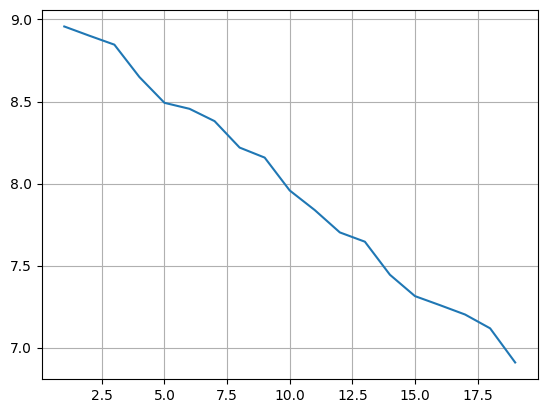

In [7]:
#Gerar um gráfico com as distorções
fig, ax = plt.subplots() # criar um objeto p/ plotar gráfico
ax.plot(K, distorcoes) #Valores de K no eixo X e valores de Distorcoes no eixo Y
ax.grid()
fig.savefig('elbow_distorcoes1.png')
plt.show()

In [8]:
#Determinar o numero otimo de grupos p/ o modelo
x0 = K[0]
y0 = distorcoes[0]
xn = K[len(K)-1]
yn = distorcoes[len(distorcoes)-1]
distancias = []

#Laço que repete o equivalente ao tamanho das distorções
for i in range(len(distorcoes)):
  x= K[i]
  y= distorcoes[i]
  numerador = abs((yn-y0)*x - (xn-x0)*y + xn*y0 - yn*x0)

  denominador = math.sqrt((yn-y0)**2 + (xn-x0)**2)

  distancias.append(numerador/denominador)

n_cluster_otimo= K[distancias.index(np.max(distancias))]
n_cluster_otimo

3

In [9]:
#Treinar o modelo de cluster definitamente
fertility_cluster = KMeans(n_clusters=n_cluster_otimo, random_state=42).fit(dados)

#Salvar o modelo treinado para uso posterior
dump(fertility_cluster, open('models/TCC_Mirnas.model', 'wb'))

#quais sao os valores dos nossos centroides
print("Centroides do modelo:")
print(fertility_cluster.cluster_centers_)

Centroides do modelo:
[[0.4902255  0.84789289 1.         ... 1.         0.30584751 1.        ]
 [0.4841664  0.6802111  0.52455701 ... 0.43183153 0.52281151 0.49425287]
 [0.5639612  0.82990392 0.72460757 ... 0.31818993 0.16248174 1.        ]]


Iniciando pré-processamento e análise...
Features selecionadas: 20
K-Means treinado com 3 clusters.
PCA treinado e dados projetados. Variância Explicada: 62.07%


c:\Users\cassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


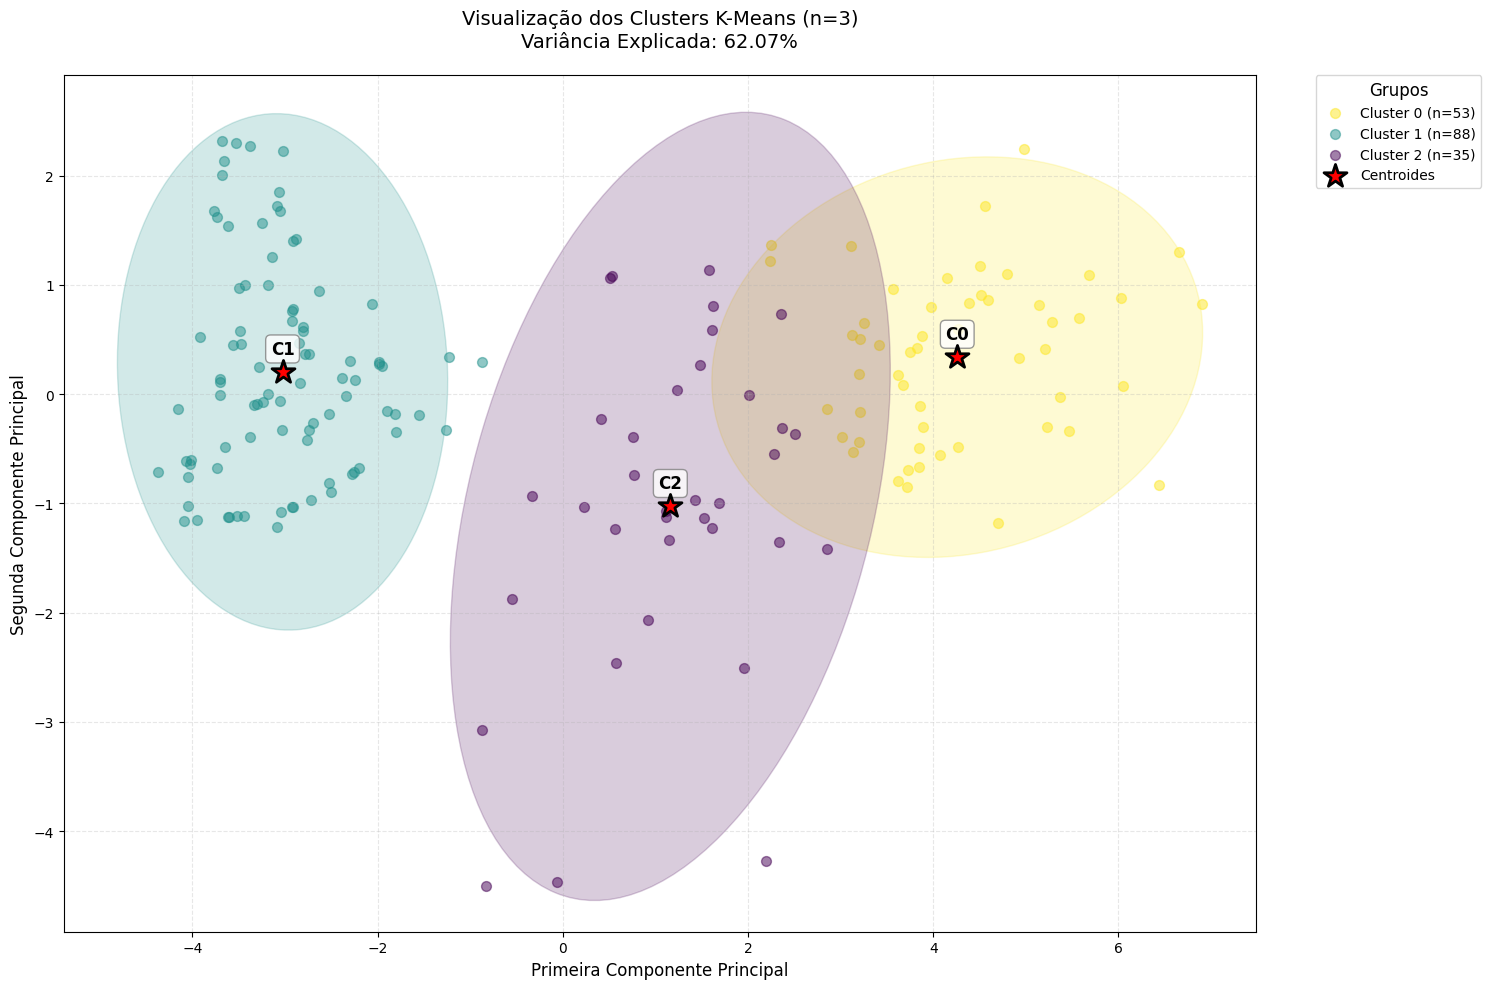

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from pickle import dump
from sklearn.preprocessing import StandardScaler

# --- 0. Funções Auxiliares (Definição da Elipse) ---

def plot_covariance_ellipse(ax, center, cov, confidence=0.95, **kwargs):
    """Desenha uma elipse que representa a dispersão de um cluster em 2D."""
    # Garantir ndarray e tipo float
    cov = np.array(cov, dtype=float)

    # Pequena regularização para evitar matrizes semi-definitas negativas por erro numérico
    cov = cov + np.eye(cov.shape[0]) * 1e-8

    # Para matrizes simétricas use eigh (mais estável) -> autovalores e autovetores
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Evitar autovalores negativos por ruído numérico
    eigvals = np.clip(eigvals, a_min=0.0, a_max=None)

    # Ordenar do maior para o menor
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # Fator de escala baseado na confiança (chi2 para 2 graus de liberdade).
    # usar a equivalência -2*ln(1-p) evita dependência do scipy.
    scale_factor = np.sqrt(-2 * np.log(1 - confidence))

    # Largura/altura da elipse = 2 * escala * sigma (sigma = sqrt(eigvals))
    width = 2.0 * np.sqrt(eigvals[0]) * scale_factor
    height = 2.0 * np.sqrt(eigvals[1]) * scale_factor

    # Ângulo da elipse (em graus) a partir do primeiro autovetor usando atan2 -> estável
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

    ell = Ellipse(xy=center, width=width, height=height, angle=angle, **kwargs)
    return ax.add_patch(ell)


# --- 1. Pré-processamento e Seleção de Features ---

print("Iniciando pré-processamento e análise...")

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dados_atributos_b)

# Selecionar features mais importantes (se dados_classe_b estiver disponível)
if 'dados_classe_b' in globals():
    selector = SelectKBest(score_func=f_classif, k=20)  # seleciona top 20 features
    X_selected = selector.fit_transform(X_scaled, dados_classe_b)
    selected_features_mask = selector.get_support()
    selected_features = dados_atributos_b.columns[selected_features_mask]
    print(f"Features selecionadas: {len(selected_features)}")
else:
    X_selected = X_scaled
    print("Usando todas as features (dados_classe_b não disponível)")

# --- 2. Re-treinar K-Means e PCA com Features Selecionadas ---

# K-Means nos dados selecionados
fertility_cluster = KMeans(n_clusters=n_cluster_otimo, random_state=42, n_init=10).fit(X_selected)
cluster_labels = fertility_cluster.labels_
n_clusters = fertility_cluster.n_clusters

# PCA nos dados selecionados
pca = PCA(n_components=2)
dados_pca = pca.fit_transform(X_selected)
centroides_pca = pca.transform(fertility_cluster.cluster_centers_)

print(f"K-Means treinado com {n_clusters} clusters.")
print(f"PCA treinado e dados projetados. Variância Explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# --- 3. Geração do Gráfico Melhorado ---

plt.figure(figsize=(15, 10))
ax = plt.gca()

# Criar um colormap personalizado
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
np.random.shuffle(colors)  # misturar cores para melhor contraste

# 3.1 Desenhar Amostras e Elipses
for i in range(n_clusters):
    cluster_data = dados_pca[cluster_labels == i]
    
    if len(cluster_data) < 2:
        print(f"Aviso: Cluster {i} tem apenas {len(cluster_data)} amostra(s). Elipse ignorada.")
        if len(cluster_data) == 1:
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1],
                      color=colors[i], alpha=0.8, s=100, marker='s',
                      label=f'Cluster {i} (1 Amostra)')
        continue

    # Plotar amostras com transparência
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1],
              color=colors[i], alpha=0.5, s=50,
              label=f'Cluster {i} (n={len(cluster_data)})')

    # Calcular e desenhar elipse
    center = np.mean(cluster_data, axis=0)
    cov_matrix = np.cov(cluster_data, rowvar=False)
    
    plot_covariance_ellipse(ax, center, cov_matrix,
                           alpha=0.2, facecolor=colors[i], edgecolor=colors[i])

# 3.2 Plotar Centroides
ax.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
          marker='*', s=300, color='red', edgecolor='black',
          linewidth=2, zorder=10, label='Centroides')

# 3.3 Anotações dos Centroides
for i in range(n_clusters):
    ax.annotate(f'C{i}',
               (centroides_pca[i, 0], centroides_pca[i, 1]),
               textcoords="offset points", xytext=(0,10),
               ha='center', va='bottom',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# 3.4 Finalização do Plot
title = f'Visualização dos Clusters K-Means (n={n_clusters})\n'
title += f'Variância Explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%'
ax.set_title(title, pad=20, fontsize=14)
ax.set_xlabel('Primeira Componente Principal', fontsize=12)
ax.set_ylabel('Segunda Componente Principal', fontsize=12)

# Ajustar legenda
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
         title='Grupos', title_fontsize=12)

# Adicionar grid e ajustar layout
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Salvar o modelo (opcional)
dump(fertility_cluster, open('models/TCC_Mirnas.model', 'wb'))

Shape original dos dados: (176, 2578)


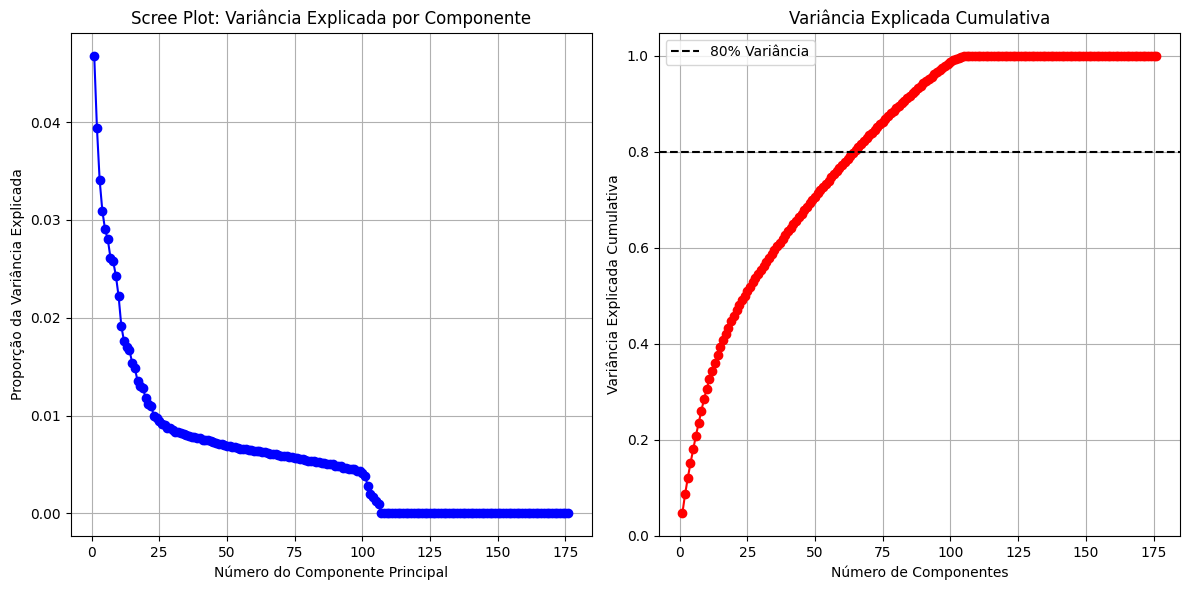

Componentes necessários para 70.0% da variância: 50
Componentes necessários para 80.0% da variância: 65
Componentes necessários para 90.0% da variância: 82

Top 10 features mais importantes:
              Feature       Score
1100  MIMAT0017991_st  245.806561
997   MIMAT0015086_st  241.625760
1481  MIMAT0019745_st  237.348873
1233  MIMAT0018938_st  197.759957
357   MIMAT0003251_st  174.394143
200   MIMAT0000773_st  171.299605
2561  MIMAT0031011_st  145.486603
2086  MIMAT0026641_st  138.804426
992   MIMAT0015081_st  127.017873
1351  MIMAT0019059_st  126.609366
137   MIMAT0000646_st  124.828064
939   MIMAT0015025_st  118.749860
500   MIMAT0004518_st  116.008074
1945  MIMAT0023252_st  115.466540
1738  MIMAT0021021_st  110.068408
1249  MIMAT0018954_st  107.736837
614   MIMAT0004784_st  107.432165
788   MIMAT0005915_st  105.666786
232   MIMAT0002177_st  104.870409
633   MIMAT0004809_st  102.982836

Variância explicada com 100 features selecionadas: 39.57%

Contribuição das features para os 2

c:\Users\cassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# @title Análise da Variância Explicada e Melhorias no PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Preparar os dados
print("Shape original dos dados:", dados_atributos_b.shape)

# 2. Padronizar os dados (importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dados_atributos_b)

# 3. Análise completa do PCA
pca_full = PCA()
pca_full.fit(X_scaled)

# 4. Calcular variância explicada cumulativa
var_ratio = pca_full.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

# 5. Plotar Scree Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(var_ratio) + 1), var_ratio, 'bo-')
plt.title('Scree Plot: Variância Explicada por Componente')
plt.xlabel('Número do Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, 'ro-')
plt.title('Variância Explicada Cumulativa')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Variância')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Encontrar número de componentes para diferentes thresholds
thresholds = [0.7, 0.8, 0.9]
for threshold in thresholds:
    n_components = np.argmax(cum_var_ratio >= threshold) + 1
    print(f"Componentes necessários para {threshold*100}% da variância: {n_components}")

# 7. Selecionar features mais importantes usando ANOVA F-value
if 'dados_classe_b' in globals():
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(dados_atributos_b, dados_classe_b)
    feature_scores = pd.DataFrame({
        'Feature': dados_atributos_b.columns,
        'Score': selector.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    print("\nTop 10 features mais importantes:")
    print(feature_scores.head(20))
    
    # 8. Aplicar PCA nos dados com features selecionadas
    k_features = 100  # ajuste este número baseado nos resultados acima
    top_features = feature_scores.nlargest(k_features, 'Score')['Feature'].values
    X_selected = dados_atributos_b[top_features]
    X_selected_scaled = StandardScaler().fit_transform(X_selected)
    
    pca_selected = PCA(n_components=2)
    pca_selected.fit(X_selected_scaled)
    
    print(f"\nVariância explicada com {k_features} features selecionadas: {pca_selected.explained_variance_ratio_.sum()*100:.2f}%")

# 9. Identificar as features que mais contribuem para os primeiros componentes
pca_components = pd.DataFrame(
    pca_full.components_[:2],
    columns=dados_atributos_b.columns
)

print("\nContribuição das features para os 2 primeiros componentes:")
for idx, comp in enumerate(pca_components.index):
    print(f"\nComponente {idx + 1} - Top 5 features:")
    print(pca_components.iloc[idx].abs().sort_values(ascending=False).head())